In [1]:
import tensorflow as tf
from model_v2 import LanguageModel
import json
import numpy as np
import re
import pandas as pd
import unicodedata
import numpy as np
import scipy
import seaborn as sns
from utils import pad_sequences, clean_text
%matplotlib inline

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
with open('102/word2idx.json', 'r') as inp:
    word2idx = json.load(inp)
with open('102/char2idx.json', 'r') as inp:
    char2idx = json.load(inp)
idx2word = {k: v for v, k in word2idx.items()}
idx2char = {k: v for v, k in char2idx.items()}

In [4]:
with open('102/checkpoints/model_configs.json', 'r') as inp:
    params = json.load(inp)

model = LanguageModel(**params, is_training=False, is_encoding=True)

model.build_model()
saver = tf.train.Saver([x for x in tf.global_variables() if x not in tf.get_collection('LSTM_SAVED_STATE')])
sess.run(tf.global_variables_initializer())
saver.restore(sess, '102/checkpoints/test/model.cpkt-278730')

INFO:tensorflow:Restoring parameters from 102/checkpoints/test/model.cpkt-278730


In [76]:
def pad_sequence(words):
    maxlen = max(len(x) for x in words)
    arr = np.zeros(shape=(len(words), 1, maxlen))
    for ir in range(len(arr)):
        s = words[ir]
        arr[ir][0][:len(s)] = s
    return arr

def __embed_sequence(sentence):
#     unk_char_idx = char2idx['U']
    sentence = [[char2idx[x] for x in word] for word in sentence]
    seq_len = len(sentence)
    inputs = pad_sequence(sentence)
    embeddings = sess.run(model.timewise_outputs[-1], feed_dict={
        model.inputs: inputs, model.seq_lens: [seq_len], model.reset_state: True
    })
    return embeddings
def embed_sentence(sentence):
    sentence = clean_text(sentence, add_bos=True, add_eos=True).split()
    print(sentence)
    return __embed_sequence(sentence)

In [77]:
def word_importance(sentence):
    tokens = clean_text(sentence, add_bos=True, add_eos=True).split()
    full_embed = __embed_sequence(tokens)
    word_omit_embed = [
        __embed_sequence(tokens[:i] + tokens[i+1:]) for i in range(len(tokens))
    ]
    return pd.DataFrame(data={'tokens': ['{} {}'.format(i, x) for i, x in enumerate(tokens[1:-1], 1)], 'importance': [scipy.spatial.distance.cosine(full_embed, x) for x in word_omit_embed[1:-1]]})

In [84]:
a = 'Hôm nay tôi ăn xoài'
b = 'Hôm nay tôi ăn bưởi'
ea = embed_sentence(a)
eb = embed_sentence(b)

['<S>', 'Hôm', 'nay', 'tôi', 'ăn', 'xoài', '</S>']
['<S>', 'Hôm', 'nay', 'tôi', 'ăn', 'bưởi', '</S>']


In [85]:
scipy.spatial.distance.cosine(ea[5][0], eb[5][0])

0.194277822971344

In [23]:
scipy.spatial.distance.cosine(ea[5][0], eb[5][0])

0.194277822971344

In [8]:
scipy.spatial.distance.cosine(ea[5][0], eb[5][0])

0.5535057485103607

In [25]:
sns.set(rc={'figure.figsize':(8, 8)})

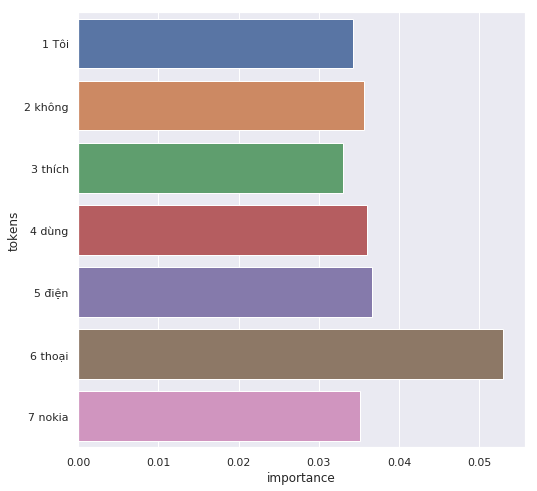

In [26]:
sns.barplot(y='tokens', x='importance', data=word_importance('Tôi không thích dùng điện thoại nokia'))

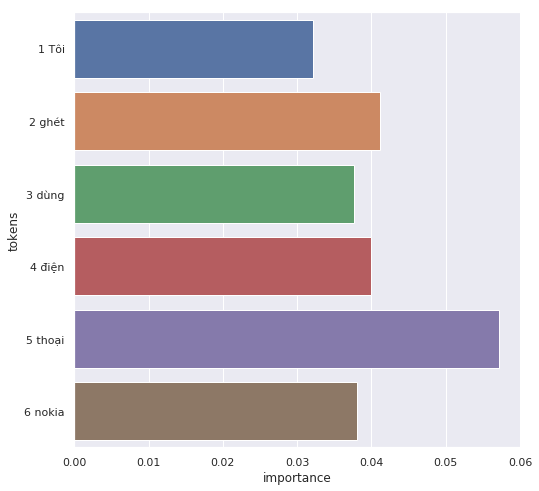

In [27]:
sns.barplot(y='tokens', x='importance', data=word_importance('Tôi ghét dùng điện thoại nokia'))

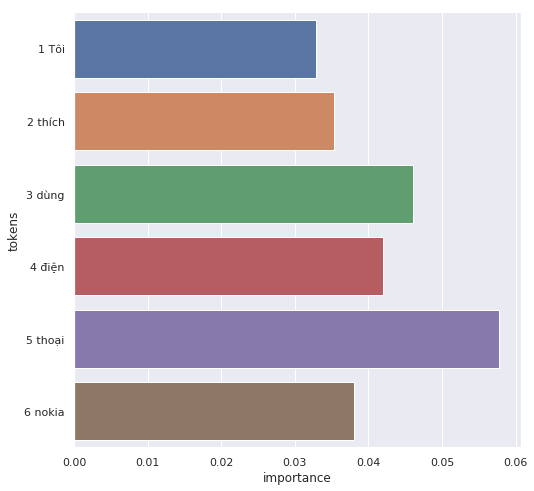

In [28]:
sns.barplot(y='tokens', x='importance', data=word_importance('Tôi thích dùng điện thoại nokia'))

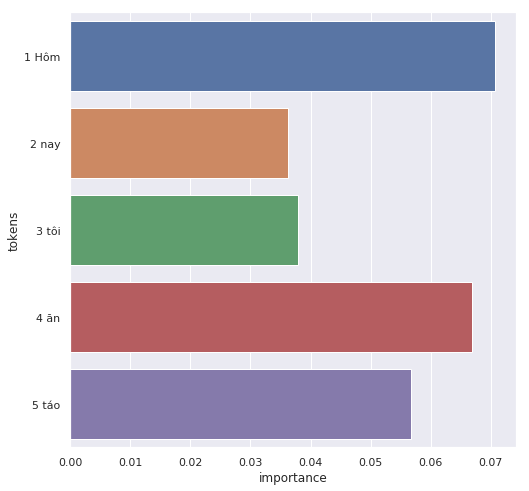

In [29]:
sns.barplot(y='tokens', x='importance', data=word_importance('Hôm nay tôi ăn táo'))

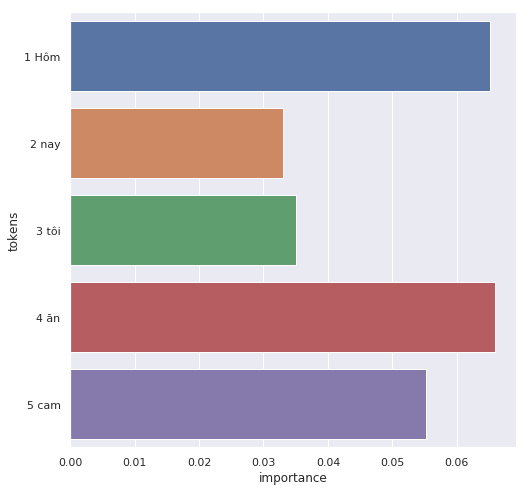

In [30]:
sns.barplot(y='tokens', x='importance', data=word_importance('Hôm nay tôi ăn cam'))

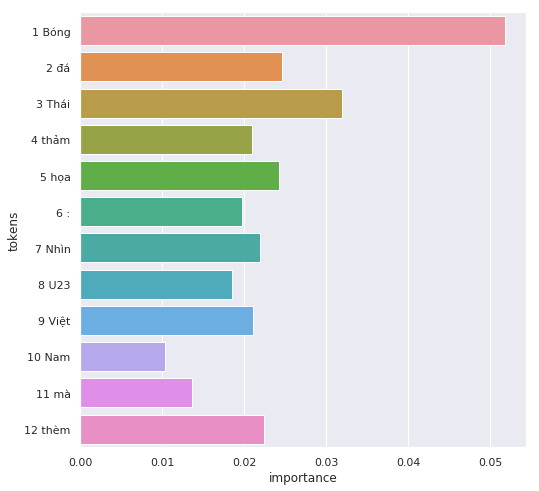

In [31]:
sns.barplot(y='tokens', x='importance', data=word_importance('Bóng đá Thái thảm họa: Nhìn U23 Việt Nam mà thèm'))

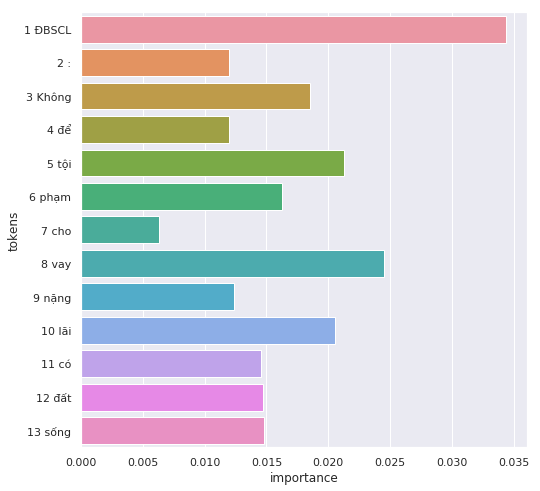

In [32]:
sns.barplot(y='tokens', x='importance', data=word_importance('ĐBSCL: Không để tội phạm cho vay nặng lãi có đất sống'))

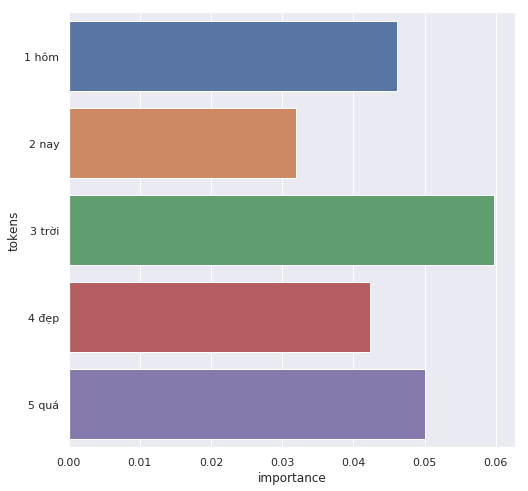

In [33]:
sns.barplot(y='tokens', x='importance', data=word_importance('hôm nay trời đẹp quá'))

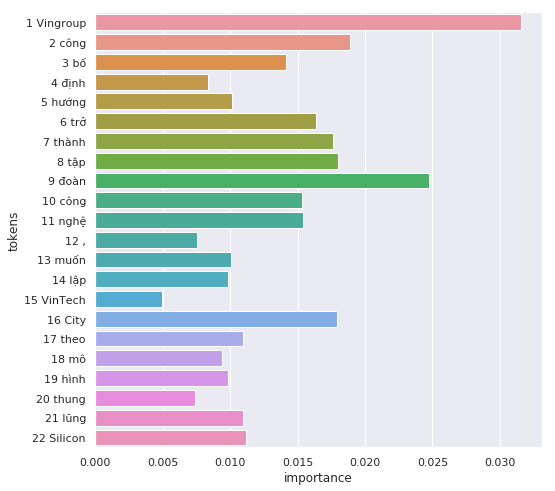

In [34]:
sns.barplot(y='tokens', x='importance', data=word_importance('Vingroup công bố định hướng trở thành tập đoàn công nghệ, muốn lập VinTech City theo mô hình thung lũng Silicon'))

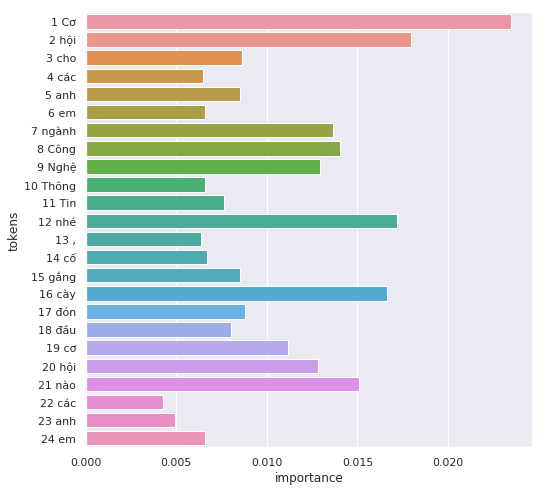

In [35]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Cơ hội cho các anh em ngành Công Nghệ Thông Tin nhé, cố gắng cày đón đầu cơ hội nào các anh em'))

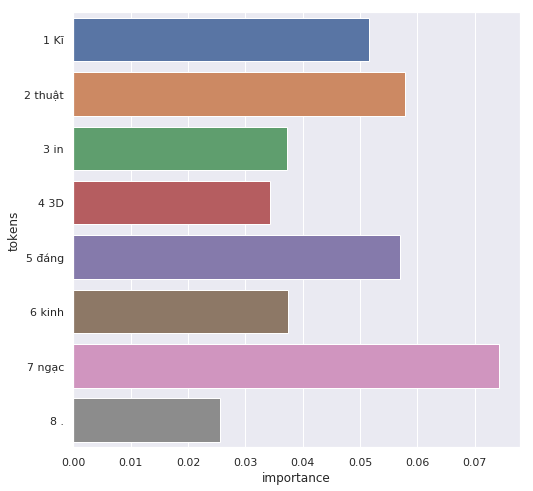

In [36]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Kĩ thuật in 3D đáng kinh ngạc.'))

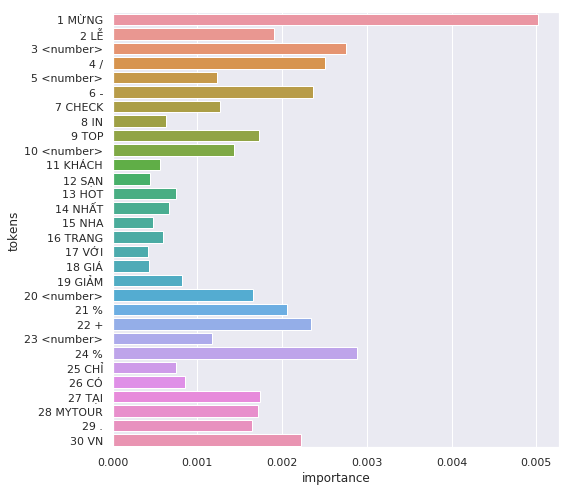

In [37]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('MỪNG LỄ 2/9 - CHECK IN TOP 5 KHÁCH SẠN HOT NHẤT NHA TRANG VỚI GIÁ GIẢM 50% + 10% CHỈ CÓ TẠI MYTOUR.VN'))

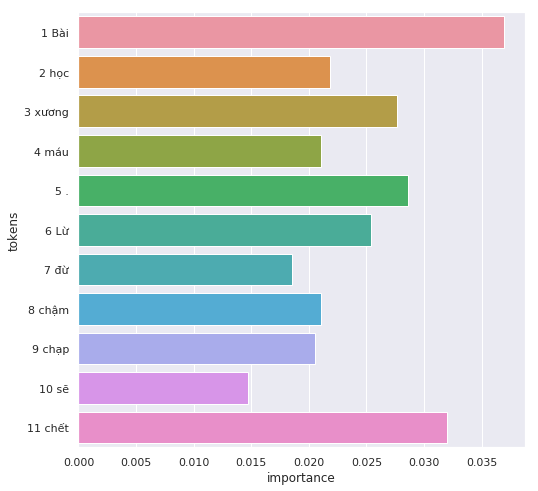

In [38]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Bài học xương máu. Lừ đừ chậm chạp sẽ chết'))

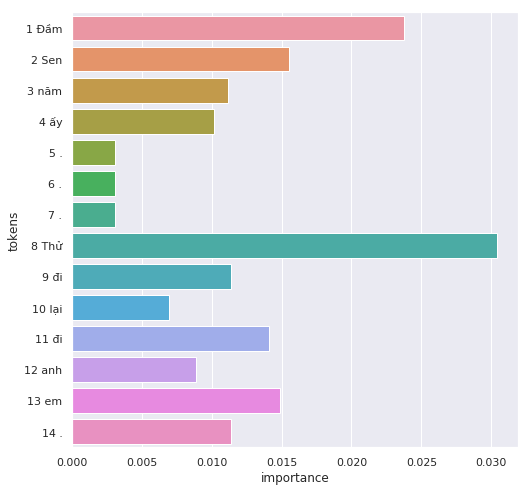

In [39]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Đầm Sen năm ấy... Thử đi lại đi anh em.'))

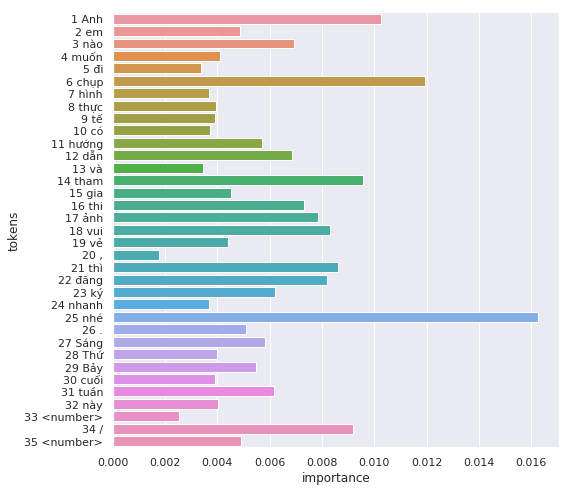

In [40]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Anh em nào muốn đi chụp hình thực tế có hướng dẫn và tham gia thi ảnh vui vẻ, thì đăng ký nhanh nhé. Sáng Thứ Bảy cuối tuần này 25/8'))

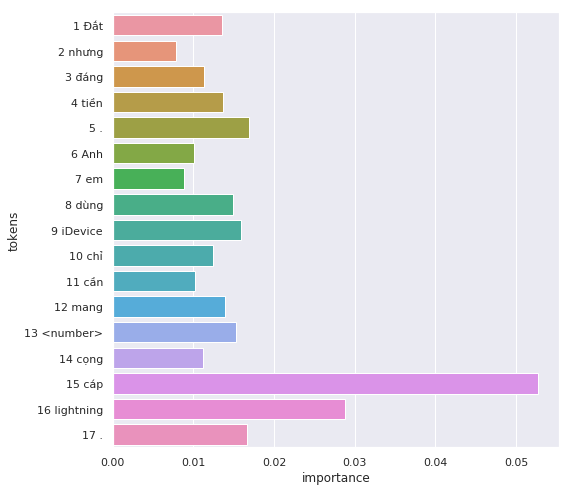

In [41]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Đắt nhưng đáng tiền. Anh em dùng iDevice chỉ cần mang 1 cọng cáp lightning.'))

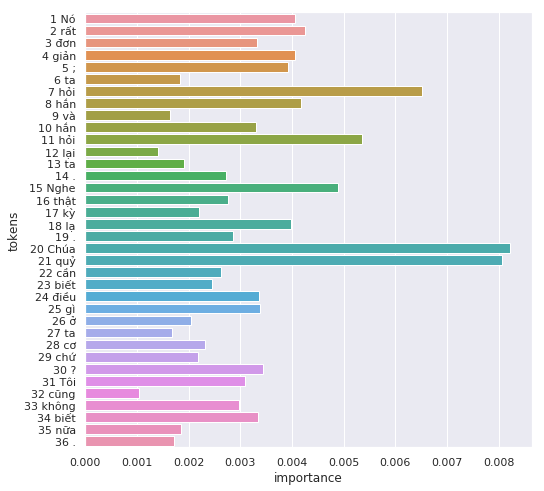

In [42]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Nó rất đơn giản; ta hỏi hắn và hắn hỏi lại ta. Nghe thật kỳ lạ. Chúa quỷ cần biết điều gì ở ta cơ chứ? Tôi cũng không biết nữa.'))

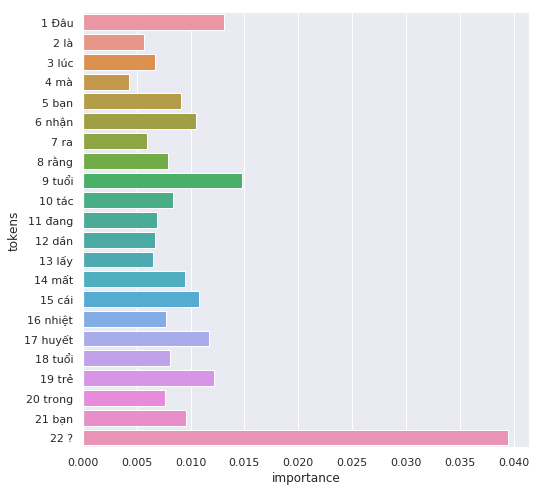

In [43]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Đâu là lúc mà bạn nhận ra rằng tuổi tác đang dần lấy mất cái nhiệt huyết tuổi trẻ trong bạn?'))

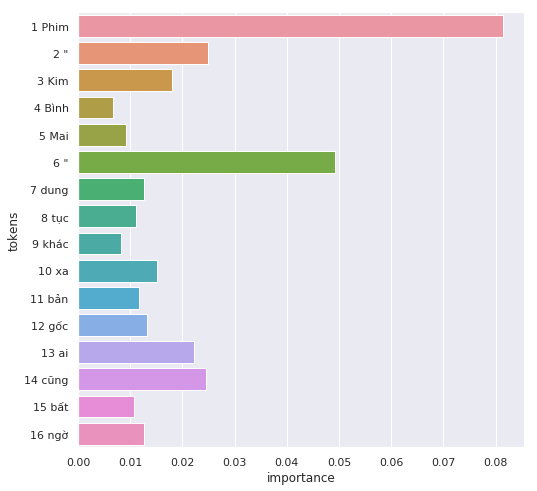

In [44]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance(
                'Phim "Kim Bình Mai" dung tục khác xa bản gốc ai cũng bất ngờ'
            ))

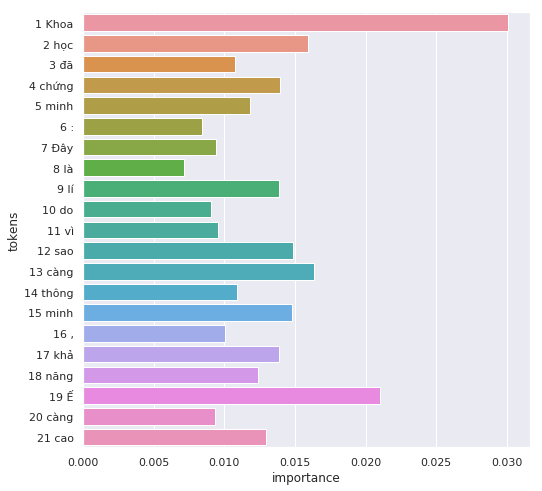

In [45]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance(
                'Khoa học đã chứng minh: Đây là lí do vì sao càng thông minh, khả năng Ế càng cao'
            ))

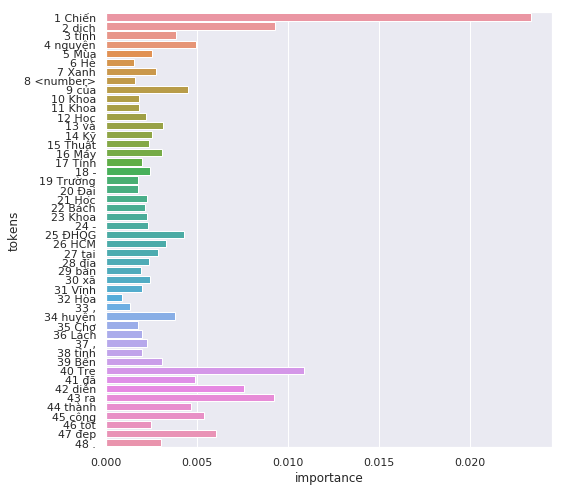

In [46]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance(
                'Chiến dịch tình nguyện Mùa Hè Xanh 2018 của Khoa Khoa Học và Kỹ Thuật Máy Tính - Trường Đại Học Bách Khoa - ĐHQG HCM tại địa bàn xã Vĩnh Hòa, huyện Chợ Lách, tỉnh Bến Tre đã diễn ra thành công tốt đẹp.'
            ))

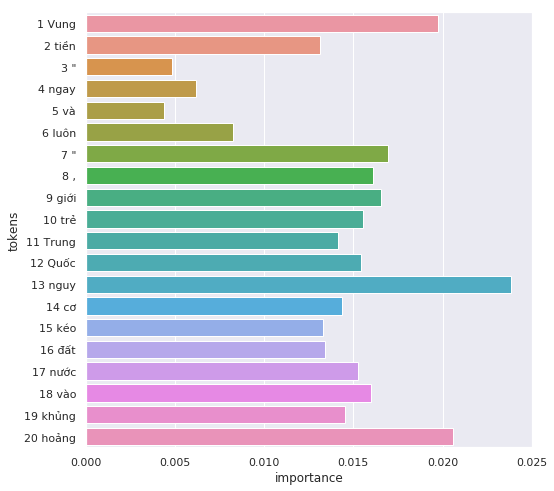

In [47]:
sns.barplot(y='tokens', x='importance', data=word_importance('Vung tiền "ngay và luôn", giới trẻ Trung Quốc nguy cơ kéo đất nước vào khủng hoảng'))

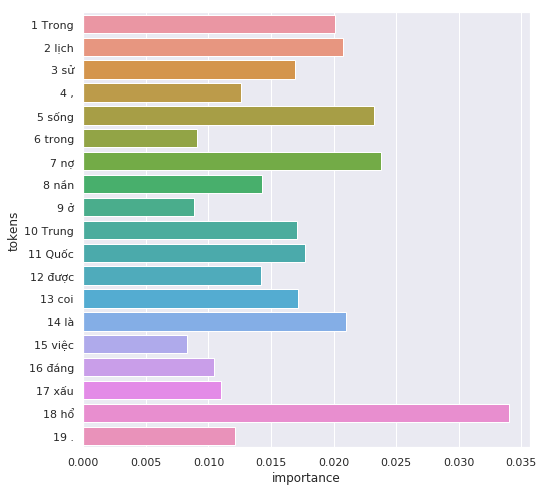

In [48]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Trong lịch sử, sống trong nợ nần ở Trung Quốc được coi là việc đáng xấu hổ.'))

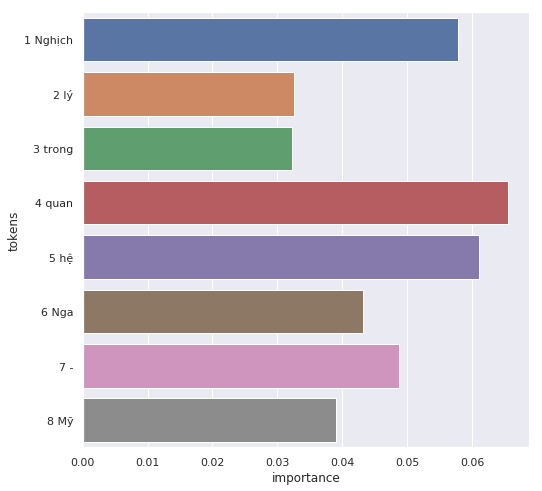

In [49]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Nghịch lý trong quan hệ Nga - Mỹ'))

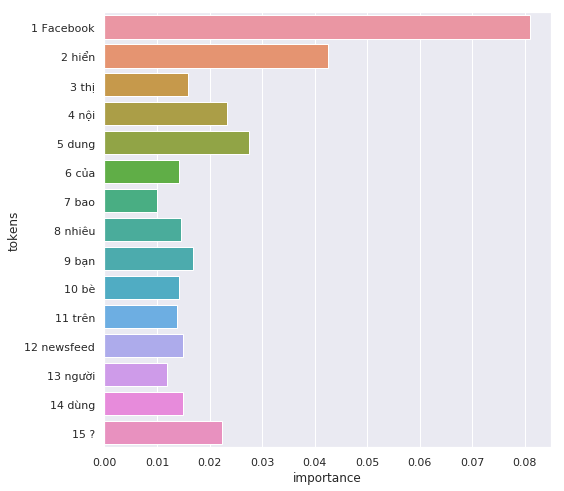

In [50]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Facebook hiển thị nội dung của bao nhiêu bạn bè trên newsfeed người dùng?'))

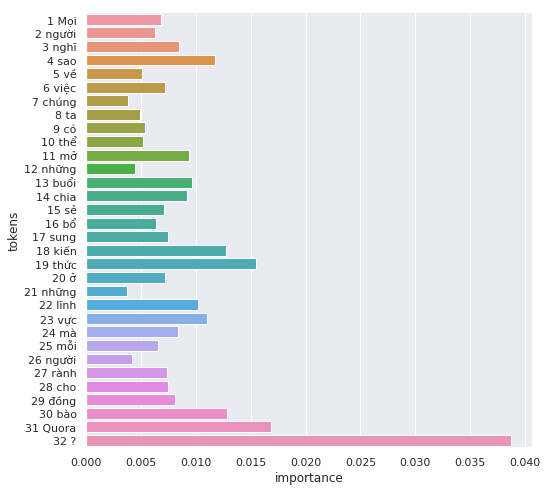

In [51]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Mọi người nghĩ sao về việc chúng ta có thể mở những buổi chia sẻ bổ sung kiến thức ở những lĩnh vực mà mỗi người rành cho đồng bào Quora?'))

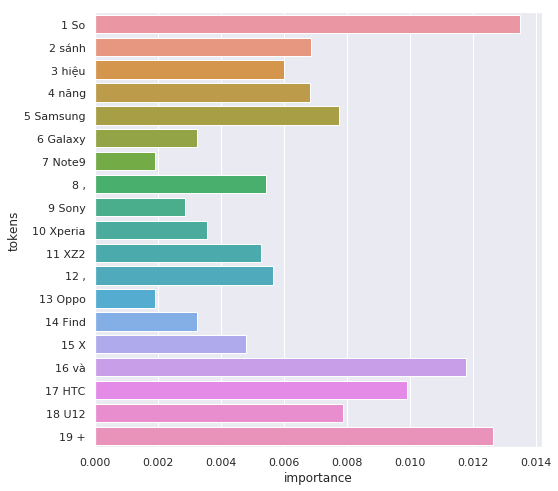

In [52]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'So sánh hiệu năng Samsung Galaxy Note9, Sony Xperia XZ2, Oppo Find X và HTC U12+'))

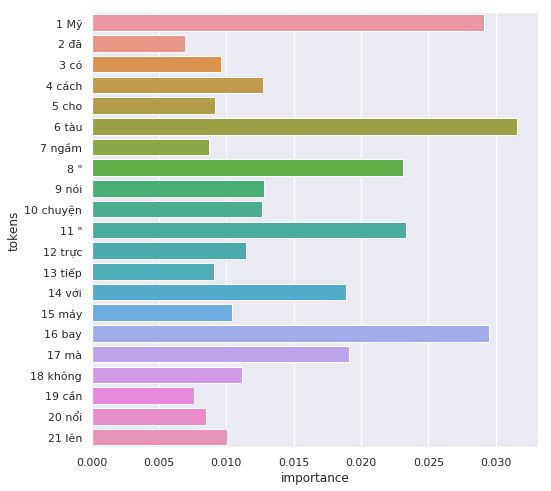

In [53]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Mỹ đã có cách cho tàu ngầm "nói chuyện" trực tiếp với máy bay mà không cần nổi lên'))

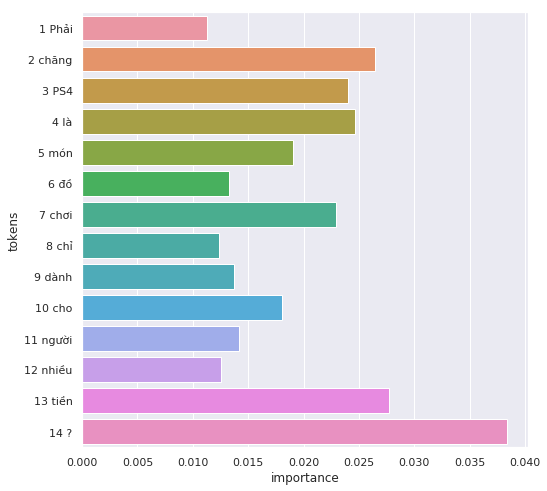

In [54]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Phải chăng PS4 là món đồ chơi chỉ dành cho người nhiều tiền?'))

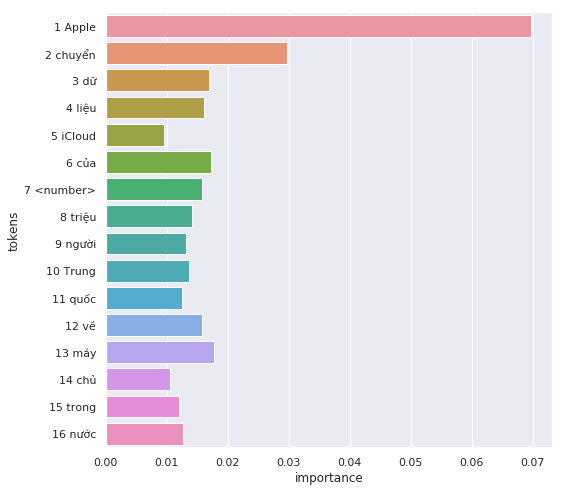

In [55]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Apple chuyển dữ liệu iCloud của 130 triệu người Trung quốc về máy chủ trong nước'))

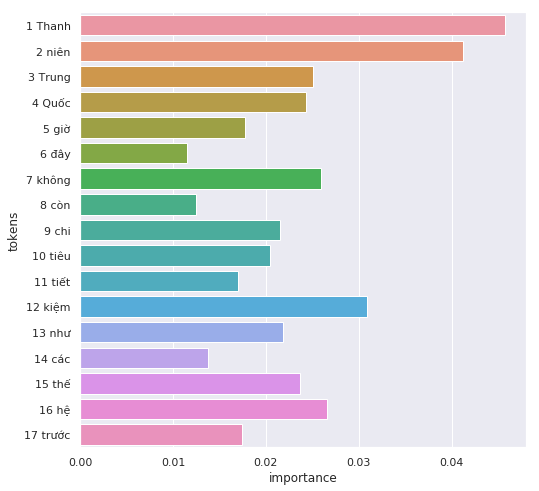

In [56]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Thanh niên Trung Quốc giờ đây không còn chi tiêu tiết kiệm như các thế hệ trước'))

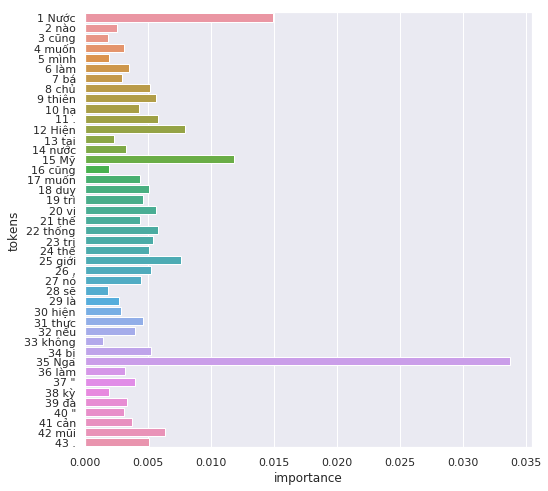

In [57]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Nước nào cũng muốn mình làm bá chủ thiên hạ. Hiện tại nước Mỹ cũng muốn duy trì vị thế thống trị thế giới, nó sẽ là hiện thực nếu không bị Nga làm "kỳ đà" cản mũi.'))

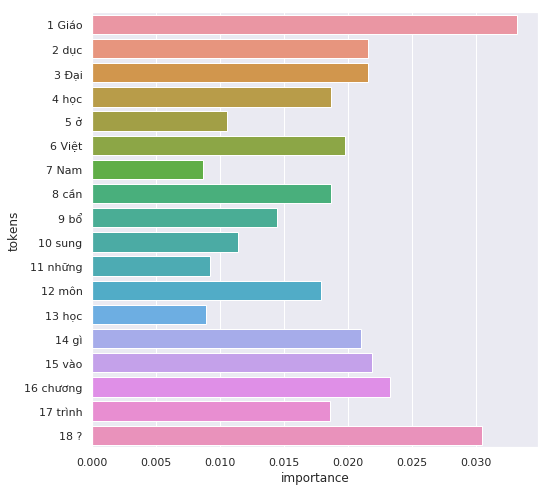

In [58]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Giáo dục Đại học ở Việt Nam cần bổ sung những môn học gì vào chương trình?'))

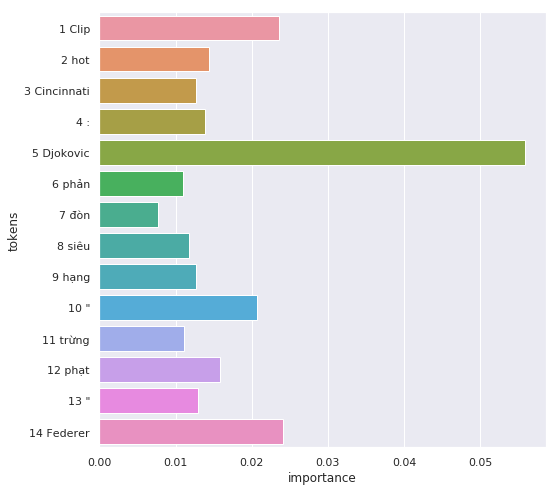

In [59]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Clip hot Cincinnati: Djokovic phản đòn siêu hạng "trừng phạt" Federer'))

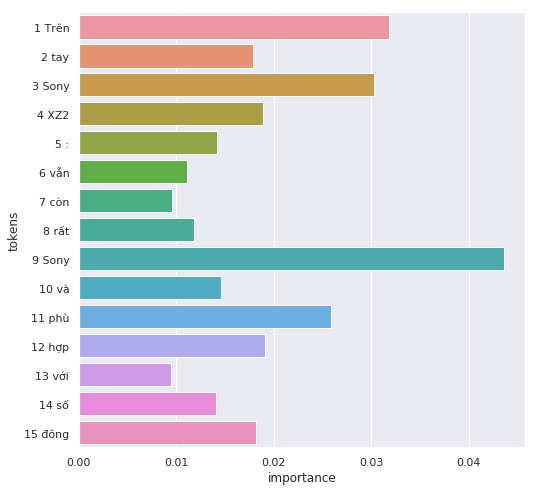

In [60]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Trên tay Sony XZ2: vẫn còn rất Sony và phù hợp với số đông'))

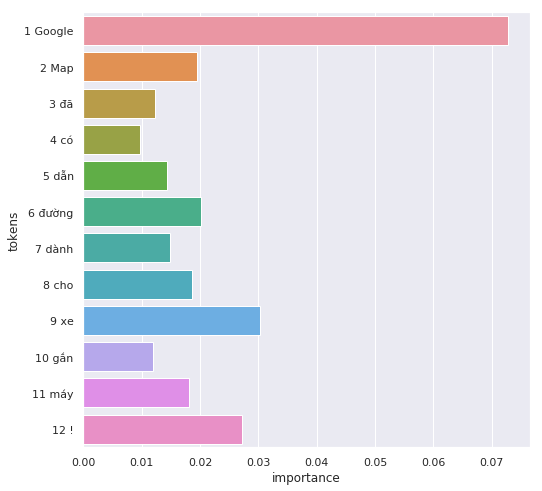

In [61]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Google Map đã có dẫn đường dành cho xe gắn máy!'))

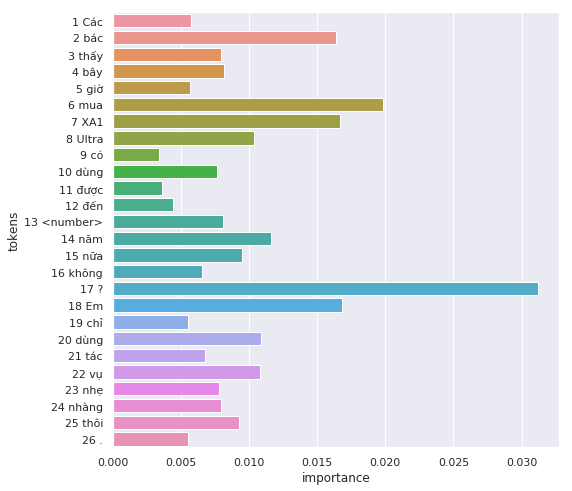

In [62]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Các bác thấy bây giờ mua XA1 Ultra có dùng được đến 5 năm nữa không? Em chỉ dùng tác vụ nhẹ nhàng thôi.'))

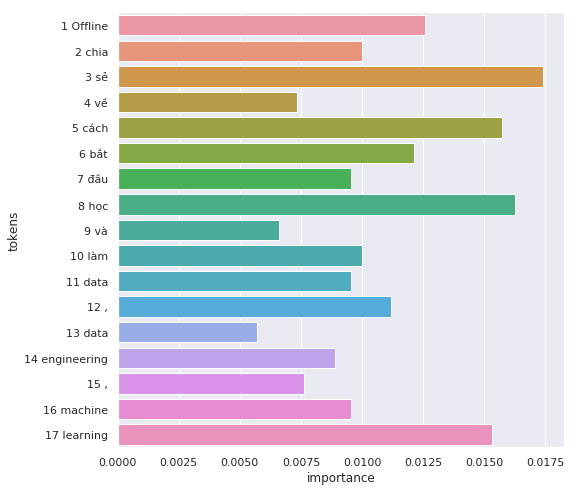

In [63]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Offline chia sẻ về cách bắt đầu học và làm data, data engineering, machine learning'))

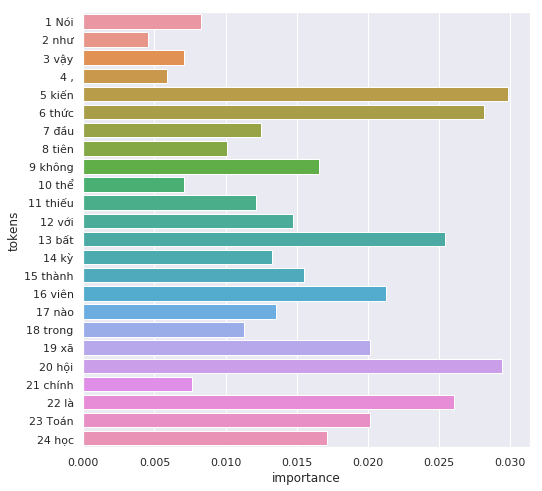

In [64]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Nói như vậy, kiến thức đầu tiên không thể thiếu với bất kỳ thành viên nào trong xã hội chính là Toán học'))

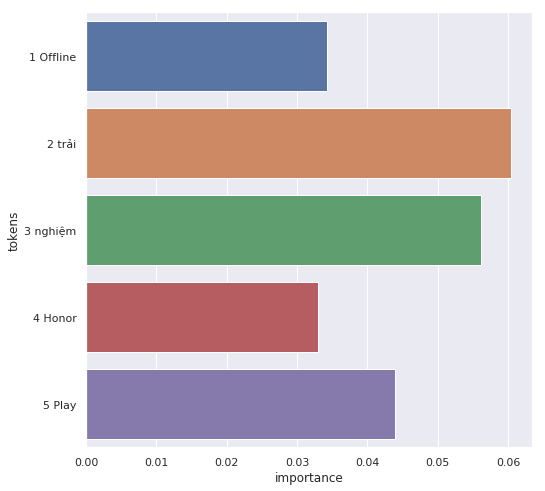

In [65]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Offline trải nghiệm Honor Play'))

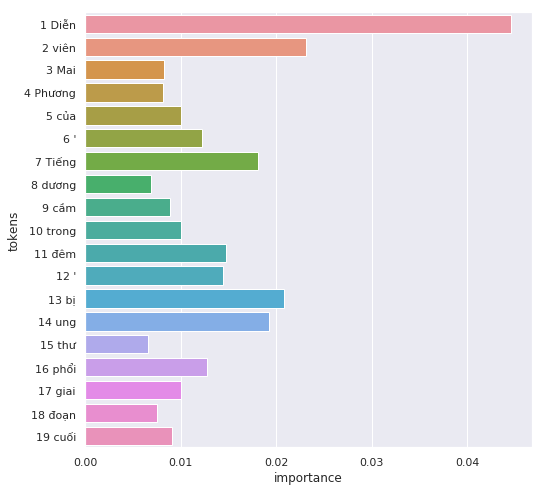

In [66]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    "Diễn viên Mai Phương của 'Tiếng dương cầm trong đêm' bị ung thư phổi giai đoạn cuối"))

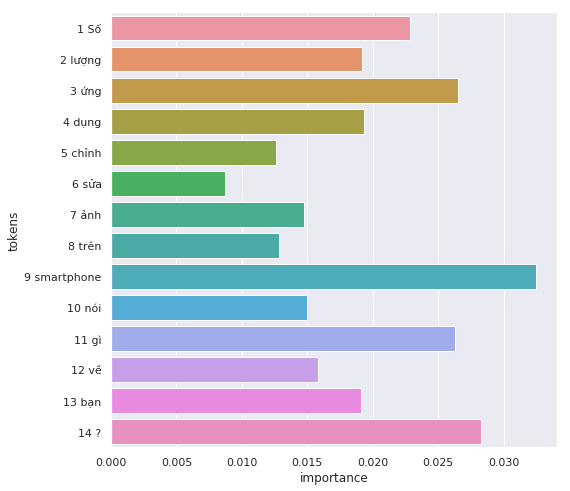

In [67]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Số lượng ứng dụng chỉnh sửa ảnh trên smartphone nói gì về bạn?'))

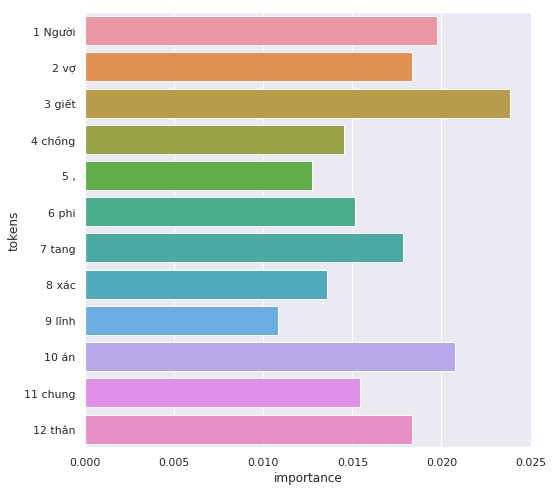

In [68]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Người vợ giết chồng, phi tang xác lĩnh án chung thân'))

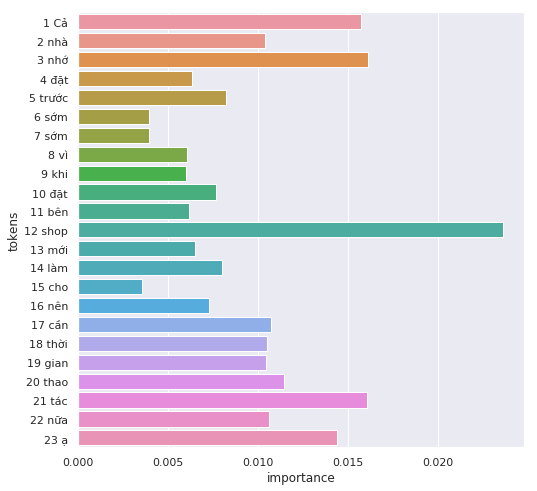

In [69]:
sns.barplot(y='tokens', x='importance', data=word_importance('Cả nhà nhớ đặt trước sớm sớm vì khi đặt bên shop mới làm cho nên cần thời gian thao tác nữa ạ'))

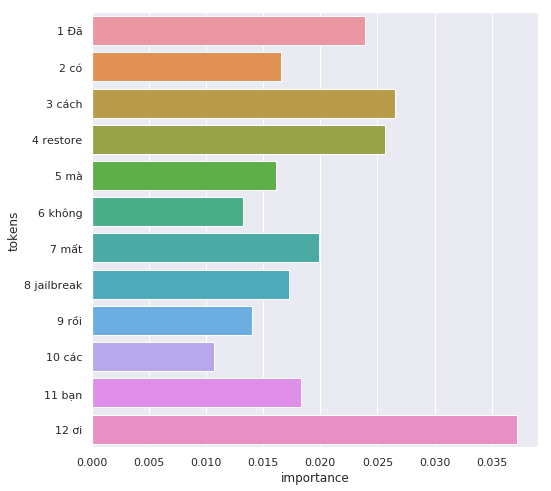

In [70]:
sns.barplot(y='tokens', x='importance', data=word_importance('Đã có cách restore mà không mất jailbreak rồi các bạn ơi'))

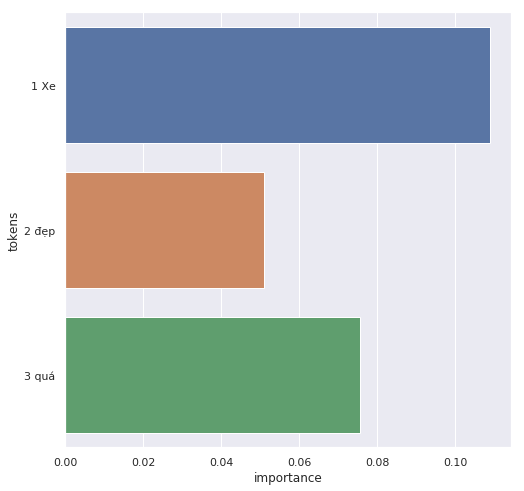

In [71]:
sns.barplot(y='tokens', x='importance', data=word_importance('Xe đẹp quá'))

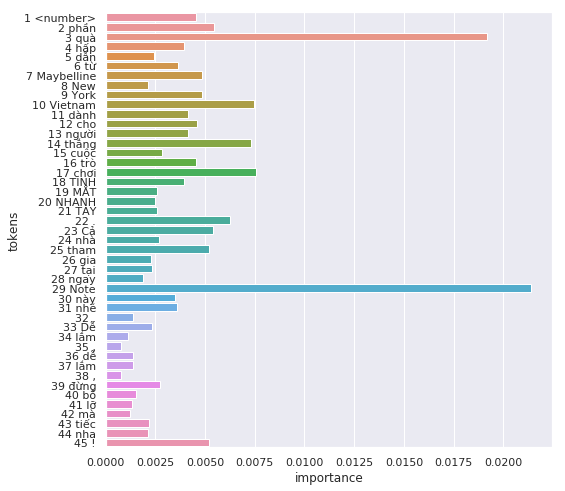

In [72]:
sns.barplot(y='tokens', x='importance', data=word_importance('3 phần quà hấp dẫn từ Maybelline New York Vietnam dành cho người thắng cuộc trò chơi TINH MẮT NHANH TAY. Cả nhà tham gia tại ngay Note này nhé. Dễ lắm, dễ lắm, đừng bỏ lỡ mà tiếc nha!'))

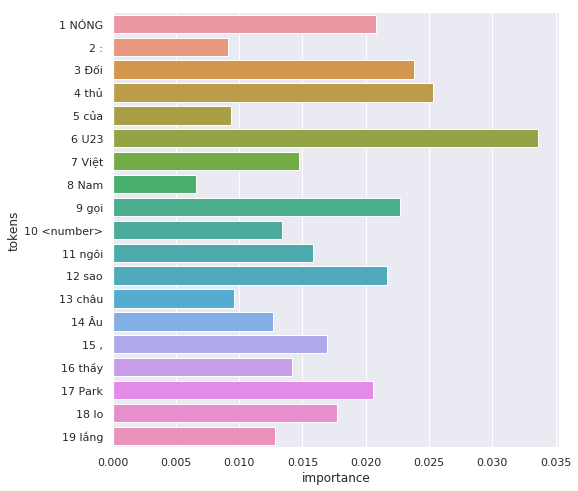

In [73]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'NÓNG: Đối thủ của U23 Việt Nam gọi 8 ngôi sao châu Âu, thầy Park lo lắng'
))

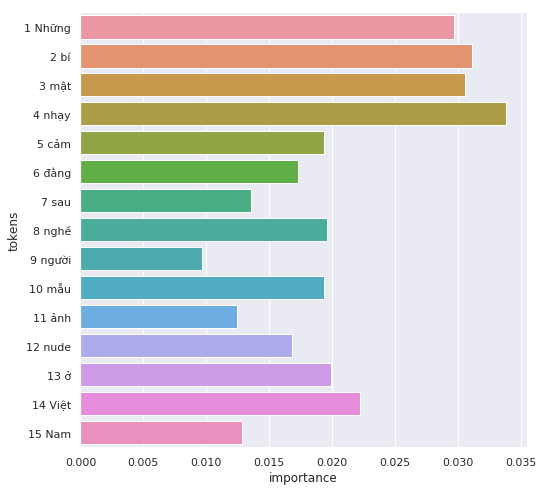

In [74]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Những bí mật nhạy cảm đằng sau nghề người mẫu ảnh nude ở Việt Nam'
))

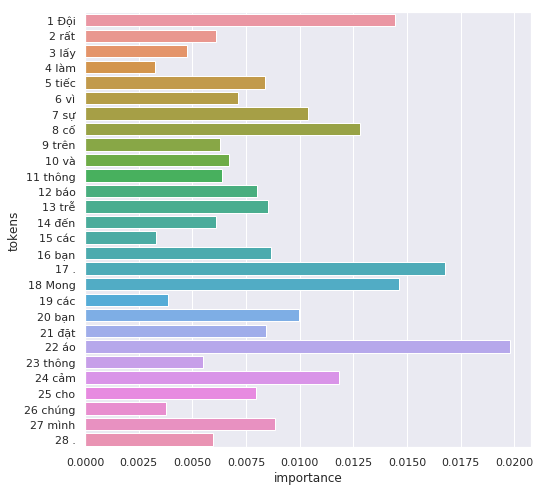

In [75]:
sns.barplot(y='tokens', x='importance', data=word_importance(
    'Đội rất lấy làm tiếc vì sự cố trên và thông báo trễ đến các bạn. Mong các bạn đặt áo thông cảm cho chúng mình.'
))